## Librairies + importation

In [13]:
import sys
sys.path.append('C:\\Users\\l.boisson\\AppData\\Local\\mambaforge\\lib\\site-packages')

from pathlib import Path
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import pandas as pd
import xarray as xr
import feather
import csv
import re
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain, product, pairwise
from more_itertools import consecutive_groups
import tkinter as tk
from tkinter import filedialog
from scipy.interpolate import interp1d

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

In [14]:
# crée une instance GUI
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

path_export = Data_Path.as_posix() + '/Exports/'
if not os.path.exists(path_export):
    os.makedirs(path_export)

## Définition des fonctions

In [15]:
def extract_file_info(file_path):
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }
    
def apply_calcul_repetitions(group):
     
    if (group['participant'].iloc[0] == '007') & (group['contraction'].iloc[0] == 'EXC'):
        force_threshold = 50
        min_consecutive = 30

    elif (group['participant'].iloc[0] == '007') & (group['contraction'].iloc[0] == 'EXC') & (group['condition'].iloc[0] == 'CTRL') & (group['essai'].iloc[0] == '3'):
        force_threshold = 40
        min_consecutive = 4
                                          
    else:
        force_threshold = 25
        min_consecutive = 4

    return calcul_repetitions(group, force_threshold, min_consecutive)

def calcul_repetitions(df, force_threshold, min_consecutive):
    df = df.copy()

    df.loc[df.Force < force_threshold, 'mouvement'] = 'Flexion'
    df.loc[df.Force >= force_threshold, 'mouvement'] = 'Extension'

    df['repetition'] = 0

    threshold_down = False
    repetition = 0

    i = 0
    while i < len(df):
        
        if df.loc[df.index[i], 'Force'] >= force_threshold and not threshold_down:
            if i + min_consecutive <= len(df) and all(df.loc[df.index[i:i+min_consecutive], 'Force'] >= force_threshold):
                repetition += 1
                threshold_down = True
                i += min_consecutive - 1
            else:
                threshold_down = False
        elif df.loc[df.index[i], 'Force'] < force_threshold:
            threshold_down = False
        df.loc[df.index[i], 'repetition'] = repetition
        i += 1

    return df

def reset_time(df):
    print(df.name)
    df.Time -= df.Time.values[0]
    return df

def resample_phase(df):
    # Calculate the step duration
    try:
        # Calculate the resampling frequency
        resampling = np.linspace(
            df["Time"].iloc[0], df["Time"].iloc[-1], num=100, endpoint = True
        )

        # Resample the data for this step using interpolation
        interp_data = df.drop("Time", axis=1).apply(
            lambda col: interp1d(df["Time"], col)(resampling)
        ).rename_axis('Cycle_%')

    except IndexError:
        print(f"Error encountered in {df.index.unique()}. Skipping this group...")
        return pd.DataFrame()
    
    return interp_data

## Extraction données data pour calcul montée en force

In [16]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("Manips/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["ISO"]:
            skiprows = 151
        else:
            skiprows = 210
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "condition", "contraction", "essai", "mesure"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Vitesse'] = df_column['Vitesse']
df_column['Angle'] = df_column['Angle']

df_column = df_column.reset_index(drop=True)
# df_column.set_index(["participant", "groupe", "condition", "contraction", "essai", "Frame"], inplace=True)

df_column

C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_CON60_1_01.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_CON60_1_02.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_CON60_1_11.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_1.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_10.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_2.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_3.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_4.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_5.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_6.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_7.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\

Force  Vitesse   Angle participant condition contraction essai  \
0        1.314   14.841 -74.999         001        CH       CON60     1   
1        1.314   15.231 -74.940         001        CH       CON60     1   
2        1.354   15.231 -74.880         001        CH       CON60     1   
3        1.110   15.231 -74.821         001        CH       CON60     1   
4        1.639   14.450 -74.764         001        CH       CON60     1   
...        ...      ...     ...         ...       ...         ...   ...   
3052690 -0.150   -0.391 -90.137         008         H         ISO     2   
3052691 -0.639    0.000 -90.137         008         H         ISO     2   
3052692 -0.883    0.391 -90.136         008         H         ISO     2   
3052693 -0.150    0.000 -90.136         008         H         ISO     2   
3052694  0.000    0.000   0.000         008         H         ISO     2   

        mesure  Frame       Time  
0           01      1   0.003906  
1           01      2   0.007812  
2           01      3   0.011719  
3           01      4   0.015625  
4           01      5   0.019531  
...        ...    ...        ...  
3052690     21   3907  15.261719  
3052691     21   3908  15.265625  
3052692     21   3909  15.269531  
3052693     21   3910  15.273438  
3052694     21   3911  15.277344  

[3052695 rows x 10 columns]

## Répétitions

In [17]:
df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(lambda x: calcul_repetitions(x)).reset_index(drop=True)

df_force_phase

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_17192\298455328.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(lambda x: calcul_repetitions(x)).reset_index(drop=True)


Force  Vitesse   Angle participant condition contraction essai  \
0        1.314   14.841 -74.999         001        CH       CON60     1   
1        1.314   15.231 -74.940         001        CH       CON60     1   
2        1.354   15.231 -74.880         001        CH       CON60     1   
3        1.110   15.231 -74.821         001        CH       CON60     1   
4        1.639   14.450 -74.764         001        CH       CON60     1   
...        ...      ...     ...         ...       ...         ...   ...   
3052690 -0.150   -0.391 -90.137         008         H         ISO     2   
3052691 -0.639    0.000 -90.137         008         H         ISO     2   
3052692 -0.883    0.391 -90.136         008         H         ISO     2   
3052693 -0.150    0.000 -90.136         008         H         ISO     2   
3052694  0.000    0.000   0.000         008         H         ISO     2   

        mesure  Frame       Time  mouvement  repetition  
0           01      1   0.003906  Extension           0  
1           01      2   0.007812  Extension           0  
2           01      3   0.011719  Extension           0  
3           01      4   0.015625  Extension           0  
4           01      5   0.019531  Extension           0  
...        ...    ...        ...        ...         ...  
3052690     21   3907  15.261719  Extension           1  
3052691     21   3908  15.265625  Extension           1  
3052692     21   3909  15.269531  Extension           1  
3052693     21   3910  15.273438  Extension           1  
3052694     21   3911  15.277344  Extension           1  

[3052695 rows x 12 columns]

In [ ]:
df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
          (df_force_phase['contraction'] == 'EXC') & 
          (df_force_phase['condition'] == 'H') & 
          (df_force_phase['essai'] == '3') & 
          (df_force_phase['repetition'] == 1) |
          (df_force_phase['repetition'] == 2) |
          (df_force_phase['repetition'] == 3))]

mask = (df_force_phase['participant'] == '007') & \
           (df_force_phase['contraction'] == 'EXC') & \
           (df_force_phase['condition'] == 'H') & \
           (df_force_phase['essai'] == '3')

for i in range(7, 3, -1):
    df_force_phase.loc[mask & (df_force_phase['repetition'] == i), 'repetition'] = i - 3
    
   
    
df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
          (df_force_phase['contraction'] == 'EXC') & 
          (df_force_phase['condition'] == 'H') & 
          (df_force_phase['essai'] == '4') & 
          (df_force_phase['repetition'] == 6))]

mask = (df_force_phase['participant'] == '006') & \
           (df_force_phase['contraction'] == 'EXC') & \
           (df_force_phase['condition'] == 'H') & \
           (df_force_phase['essai'] == '4')

for i in range(7, 6, -1):
    df_force_phase.loc[mask & (df_force_phase['repetition'] == i), 'repetition'] = i - 1    
    
df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
          (df_force_phase['contraction'] == 'EXC') & 
          (df_force_phase['condition'] == 'CH') & 
          (df_force_phase['essai'] == '3') & 
          (df_force_phase['repetition'] == 1) & 
          (df_force_phase['repetition'] == 2))]

mask = (df_force_phase['participant'] == '006') & \
           (df_force_phase['contraction'] == 'EXC') & \
           (df_force_phase['condition'] == 'CH') & \
           (df_force_phase['essai'] == '3')

for i in range(7, 2, -1):
    df_force_phase.loc[mask & (df_force_phase['repetition'] == i), 'repetition'] = i - 2  

## Reset time

In [18]:
df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], group_keys=False).apply(reset_time)
df_force_phase

('001', 'CH', 'CON60', '1', '01', 'Extension', 0)
('001', 'CH', 'CON60', '1', '01', 'Extension', 1)
('001', 'CH', 'CON60', '1', '01', 'Extension', 2)
('001', 'CH', 'CON60', '1', '01', 'Extension', 3)
('001', 'CH', 'CON60', '1', '01', 'Extension', 4)
('001', 'CH', 'CON60', '1', '01', 'Flexion', 0)
('001', 'CH', 'CON60', '1', '01', 'Flexion', 1)
('001', 'CH', 'CON60', '1', '01', 'Flexion', 2)
('001', 'CH', 'CON60', '1', '01', 'Flexion', 3)
('001', 'CH', 'CON60', '1', '01', 'Flexion', 4)
('001', 'CH', 'CON60', '1', '02', 'Extension', 0)
('001', 'CH', 'CON60', '1', '02', 'Extension', 1)
('001', 'CH', 'CON60', '1', '02', 'Extension', 2)
('001', 'CH', 'CON60', '1', '02', 'Extension', 3)
('001', 'CH', 'CON60', '1', '02', 'Extension', 4)
('001', 'CH', 'CON60', '1', '02', 'Flexion', 0)
('001', 'CH', 'CON60', '1', '02', 'Flexion', 1)
('001', 'CH', 'CON60', '1', '02', 'Flexion', 2)
('001', 'CH', 'CON60', '1', '02', 'Flexion', 3)
('001', 'CH', 'CON60', '1', '02', 'Flexion', 4)
('001', 'CH', 'CON60

Force  Vitesse   Angle participant condition contraction essai  \
0        1.314   14.841 -74.999         001        CH       CON60     1   
1        1.314   15.231 -74.940         001        CH       CON60     1   
2        1.354   15.231 -74.880         001        CH       CON60     1   
3        1.110   15.231 -74.821         001        CH       CON60     1   
4        1.639   14.450 -74.764         001        CH       CON60     1   
...        ...      ...     ...         ...       ...         ...   ...   
3052690 -0.150   -0.391 -90.137         008         H         ISO     2   
3052691 -0.639    0.000 -90.137         008         H         ISO     2   
3052692 -0.883    0.391 -90.136         008         H         ISO     2   
3052693 -0.150    0.000 -90.136         008         H         ISO     2   
3052694  0.000    0.000   0.000         008         H         ISO     2   

        mesure  Frame      Time  mouvement  repetition  
0           01      1  0.000000  Extension           0  
1           01      2  0.003906  Extension           0  
2           01      3  0.007812  Extension           0  
3           01      4  0.011719  Extension           0  
4           01      5  0.015625  Extension           0  
...        ...    ...       ...        ...         ...  
3052690     21   3907  0.425781  Extension           1  
3052691     21   3908  0.429688  Extension           1  
3052692     21   3909  0.433594  Extension           1  
3052693     21   3910  0.437500  Extension           1  
3052694     21   3911  0.441406  Extension           1  

[3052695 rows x 12 columns]

## Resample

In [19]:
df_flexion = df_force_phase[df_force_phase['mouvement'] == 'Extension']
df_flexion.reset_index()
df_flexion.set_index(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], inplace = True)
df_flexion_interpol = df_flexion.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition']).apply(resample_phase)
df_flexion_interpol.reset_index(inplace=True)

df_flexion_interpol

participant condition contraction essai mesure mouvement  repetition  \
0              001        CH       CON60     1     01   Flexion           0   
1              001        CH       CON60     1     01   Flexion           0   
2              001        CH       CON60     1     01   Flexion           0   
3              001        CH       CON60     1     01   Flexion           0   
4              001        CH       CON60     1     01   Flexion           0   
...            ...       ...         ...   ...    ...       ...         ...   
256595         008         H         ISO     2     21   Flexion           1   
256596         008         H         ISO     2     21   Flexion           1   
256597         008         H         ISO     2     21   Flexion           1   
256598         008         H         ISO     2     21   Flexion           1   
256599         008         H         ISO     2     21   Flexion           1   

        Cycle_%       Force   Vitesse       Angle        Frame  
0             0   26.745000 -5.077000 -107.579000   702.000000  
1             1   34.083731 -5.478520 -107.594965   719.505051  
2             2   33.824888 -5.931831 -107.570088   737.010101  
3             3   33.566046 -6.385143 -107.545211   754.515152  
4             4   33.307203 -6.838455 -107.520333   772.020202  
...         ...         ...       ...         ...          ...  
256595       95  301.580232  0.000000  -90.104000  3739.828283  
256596       96  263.262848 -0.343606  -90.105000  3754.121212  
256597       97  157.949414 -0.229071  -90.110000  3768.414141  
256598       98   71.938131 -0.114535  -90.124000  3782.707071  
256599       99   25.240000  0.000000  -90.131000  3797.000000  

[256600 rows x 12 columns]

# Contraction concentrique

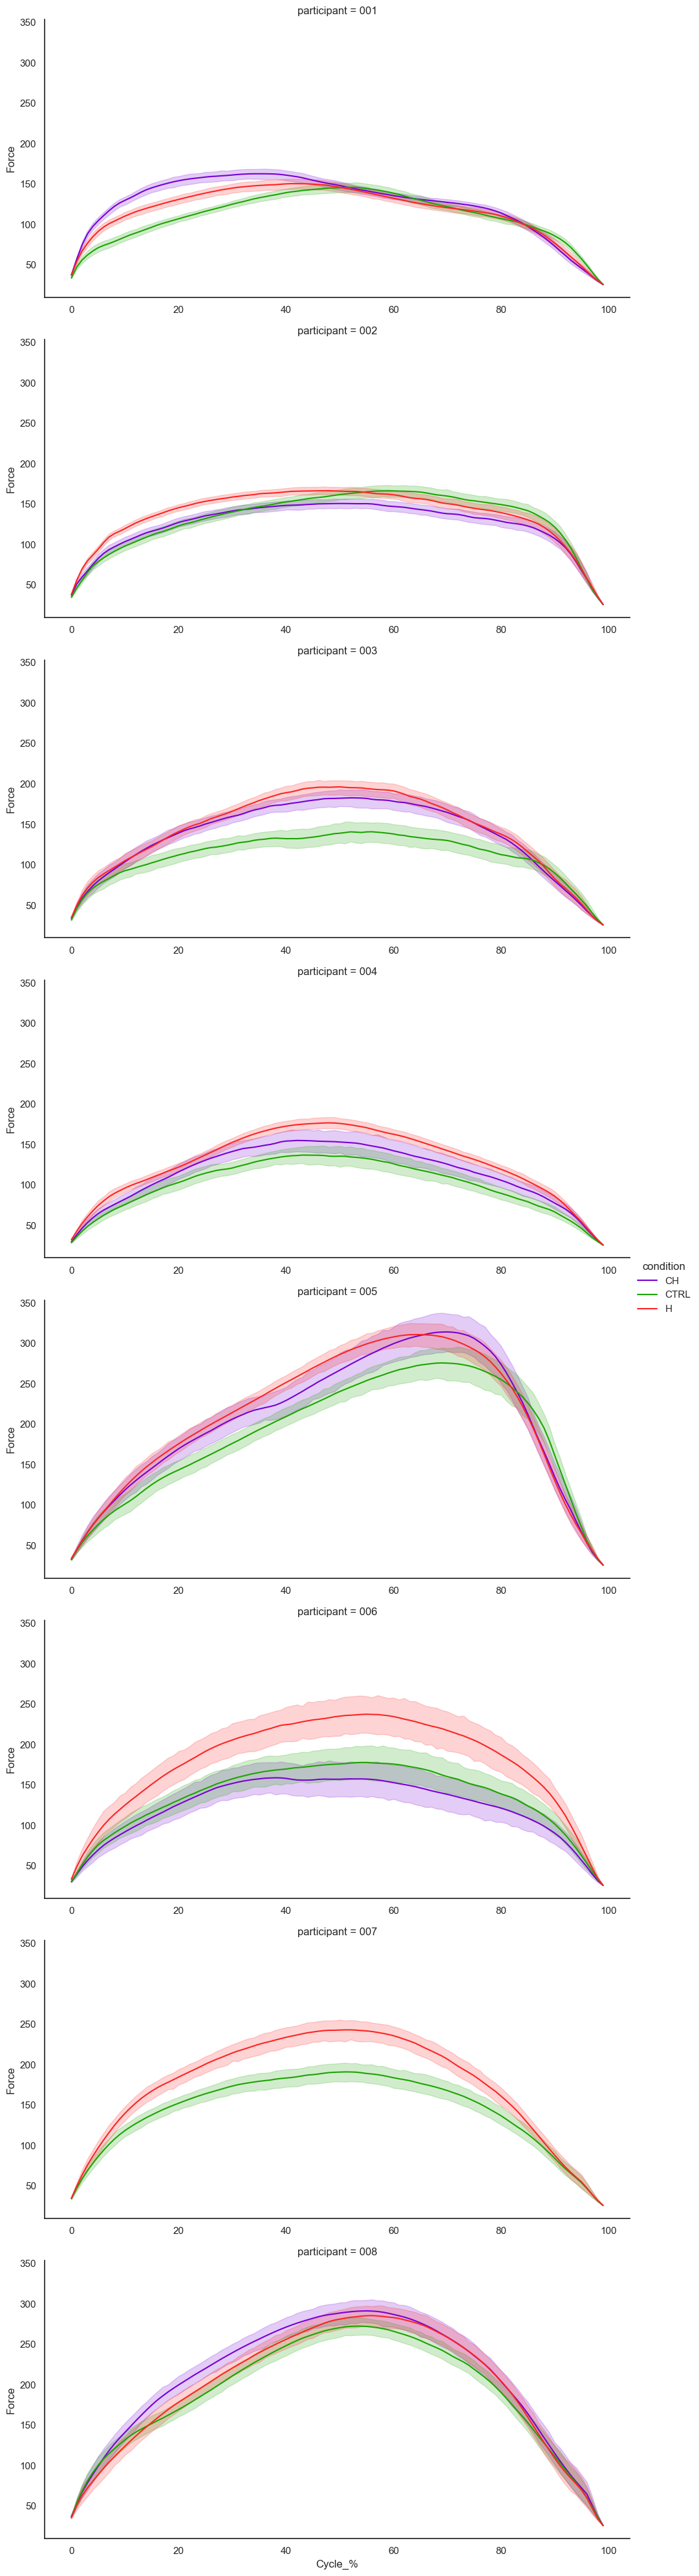

In [20]:
data_plot = df_flexion_interpol[
    # (df_flexion_interpol['participant'] == '001')
    (df_flexion_interpol['repetition'] != 0)
    # & (df_flexion_interpol['essai'] == '1')
    & (df_flexion_interpol['mouvement'] == 'Extension')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
            #  col = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )

# Contraction excentrique

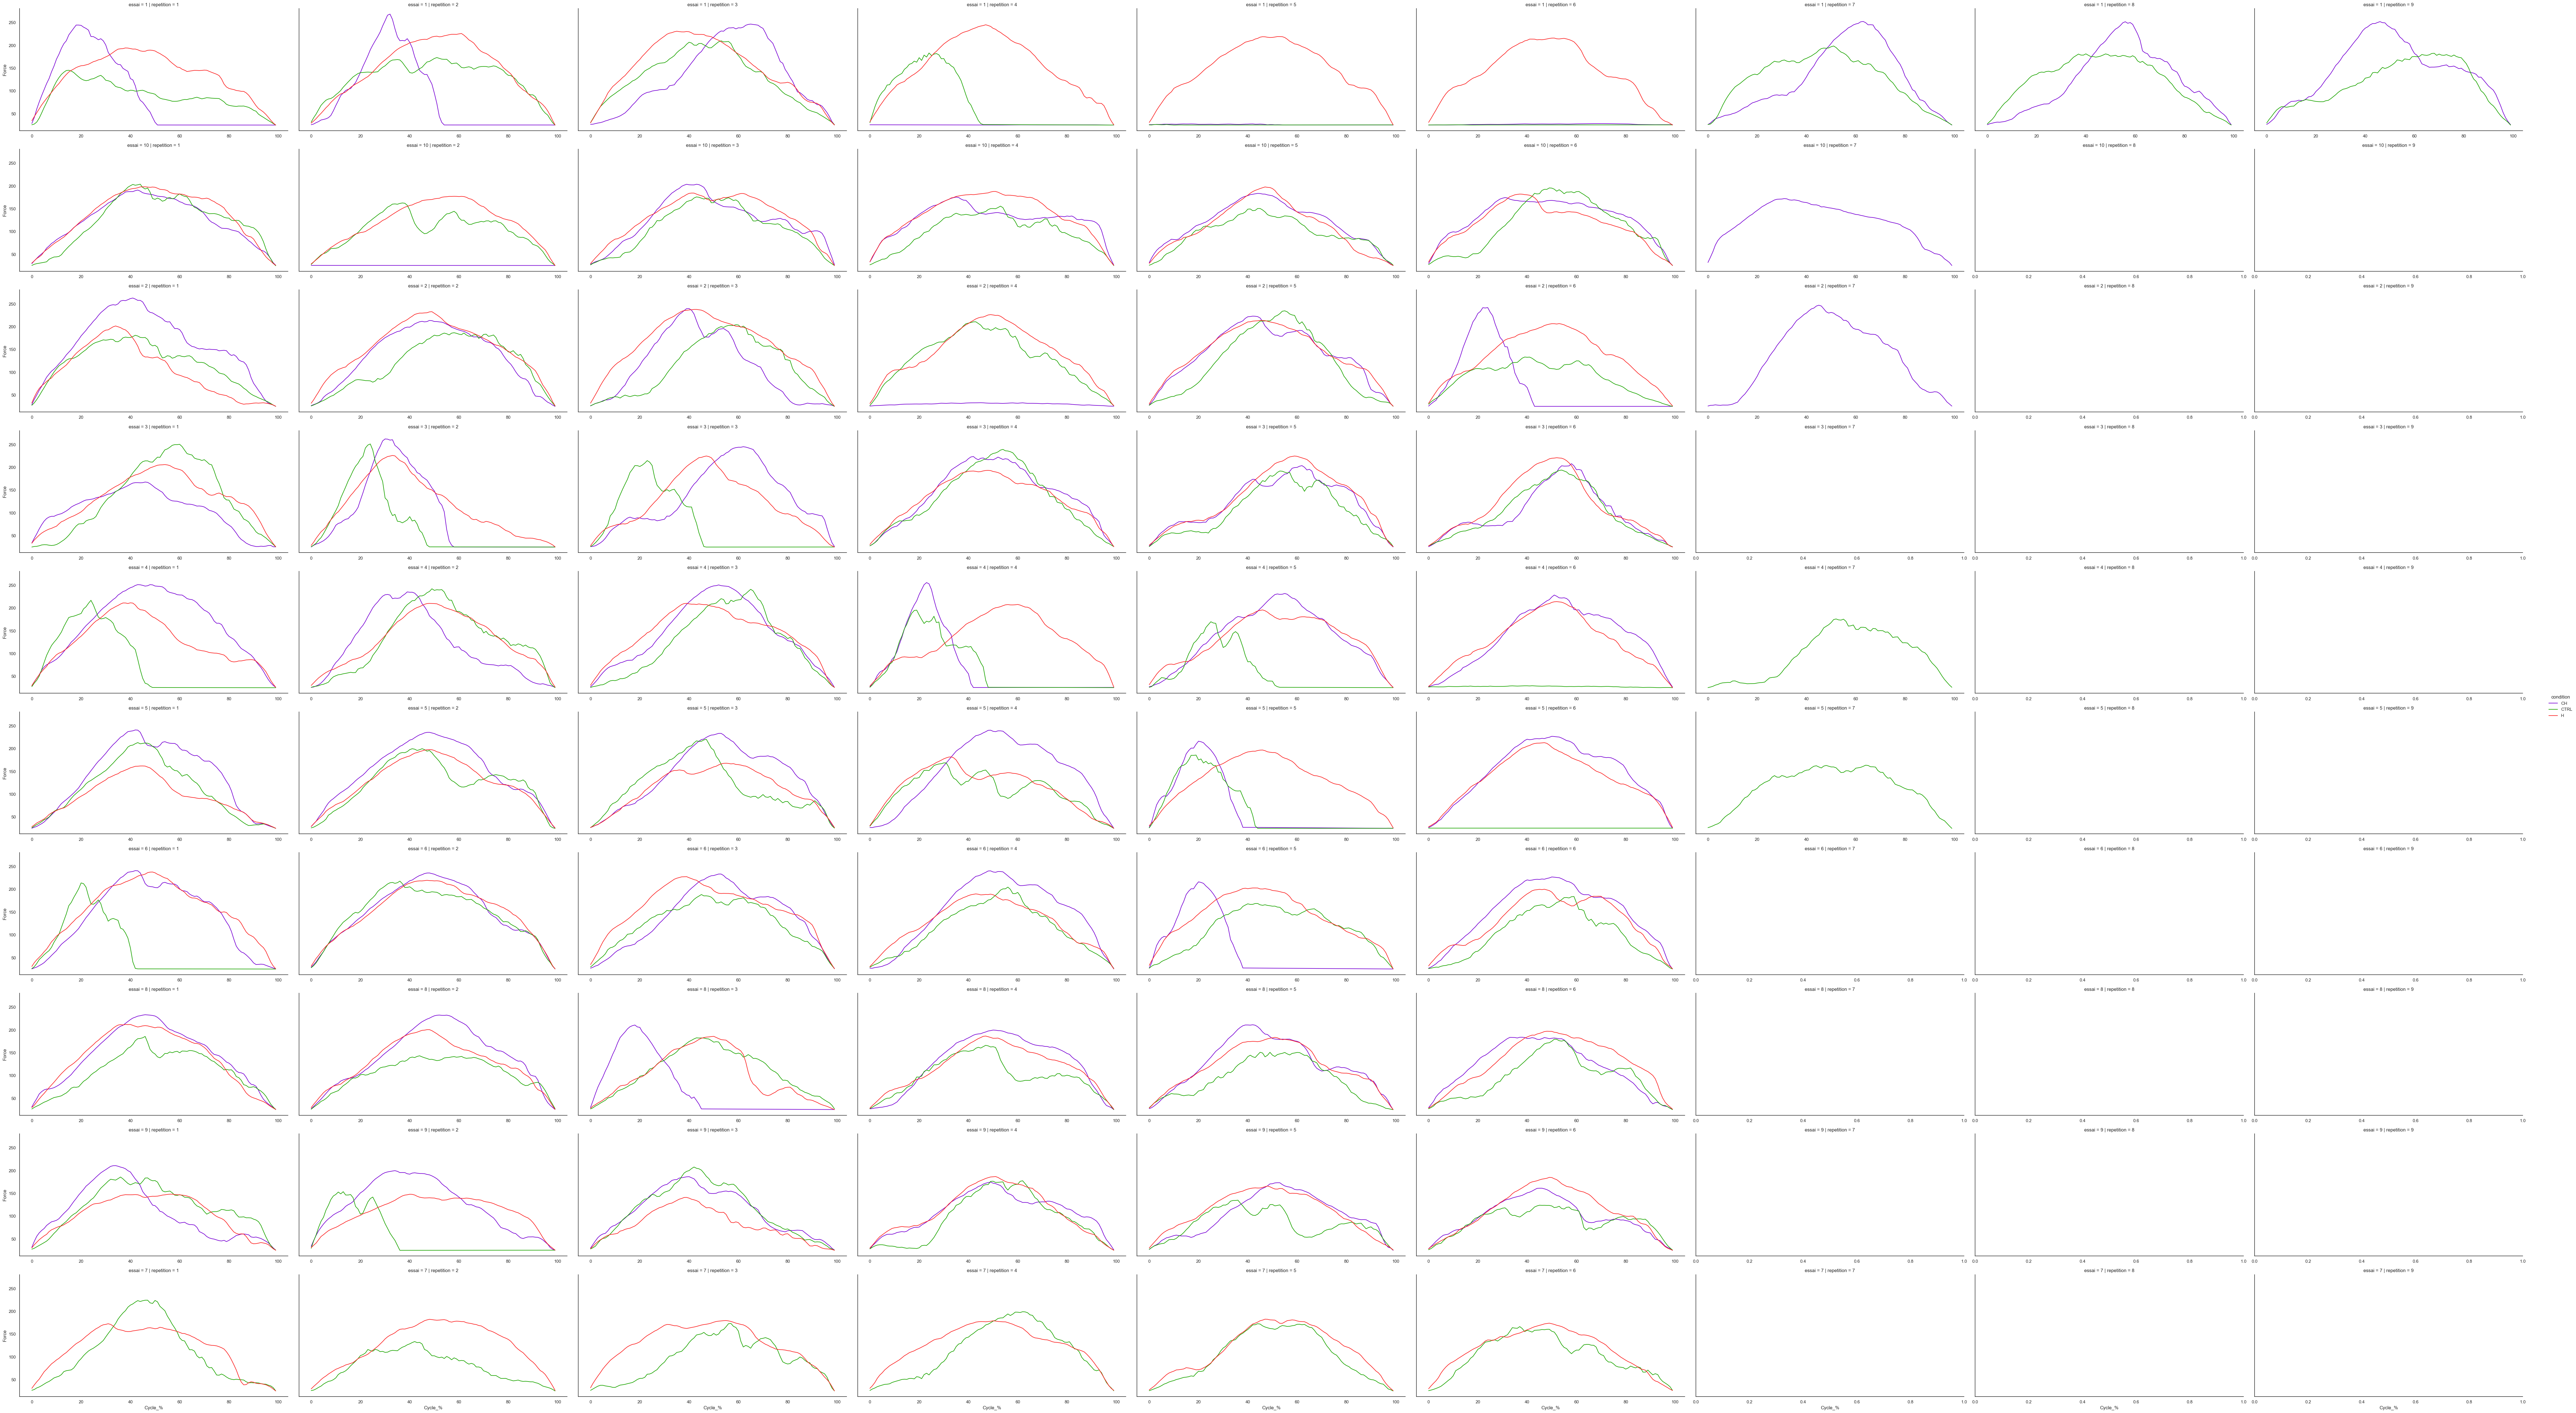

In [30]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_flexion_interpol['mouvement'] == 'Flexion')
    & (df_flexion_interpol['contraction'] == 'EXC')
    & (df_flexion_interpol['participant'] == '004')
    # & (df_flexion_interpol['repetition'] == '04')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
             x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'essai',
             col = 'repetition',
             palette=palette_colors,
             facet_kws=dict(sharex=False),
             errorbar = 'sd'
             )

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_17192\2442586137.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_plot = df_flexion_interpol[


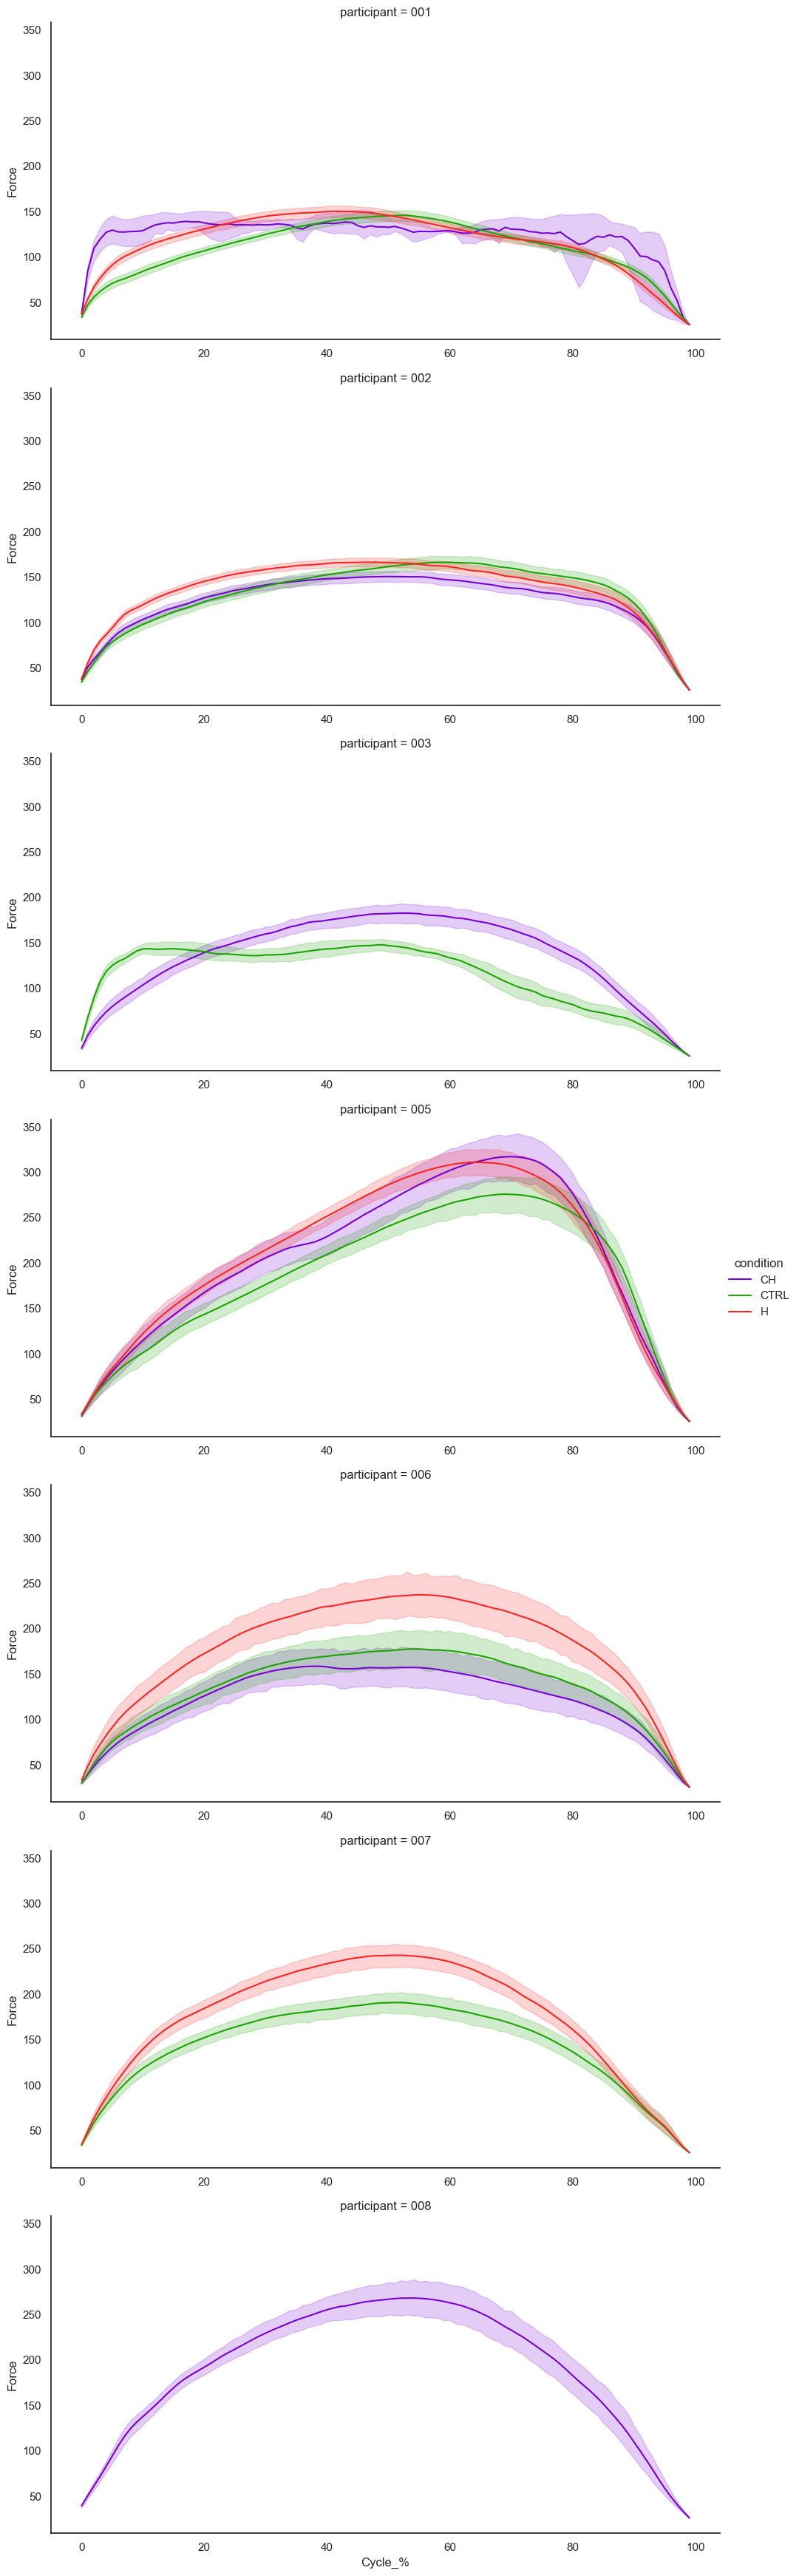

In [32]:
data_plot = df_flexion_interpol[
    # (df_flexion_interpol['participant'] == '001')
    (df_flexion_interpol['repetition'] != 0)
    # & (df_force_phase['condition'] == 'CTRL')
    & (df_force_phase['contraction'] == 'EXC')
    # & (df_flexion_interpol['essai'] == '8')
    # (df_force_phase['mesure'] == '01')
    & (df_flexion_interpol['mouvement'] == 'Flexion')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
            #  col = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )


# Contraction isométrique

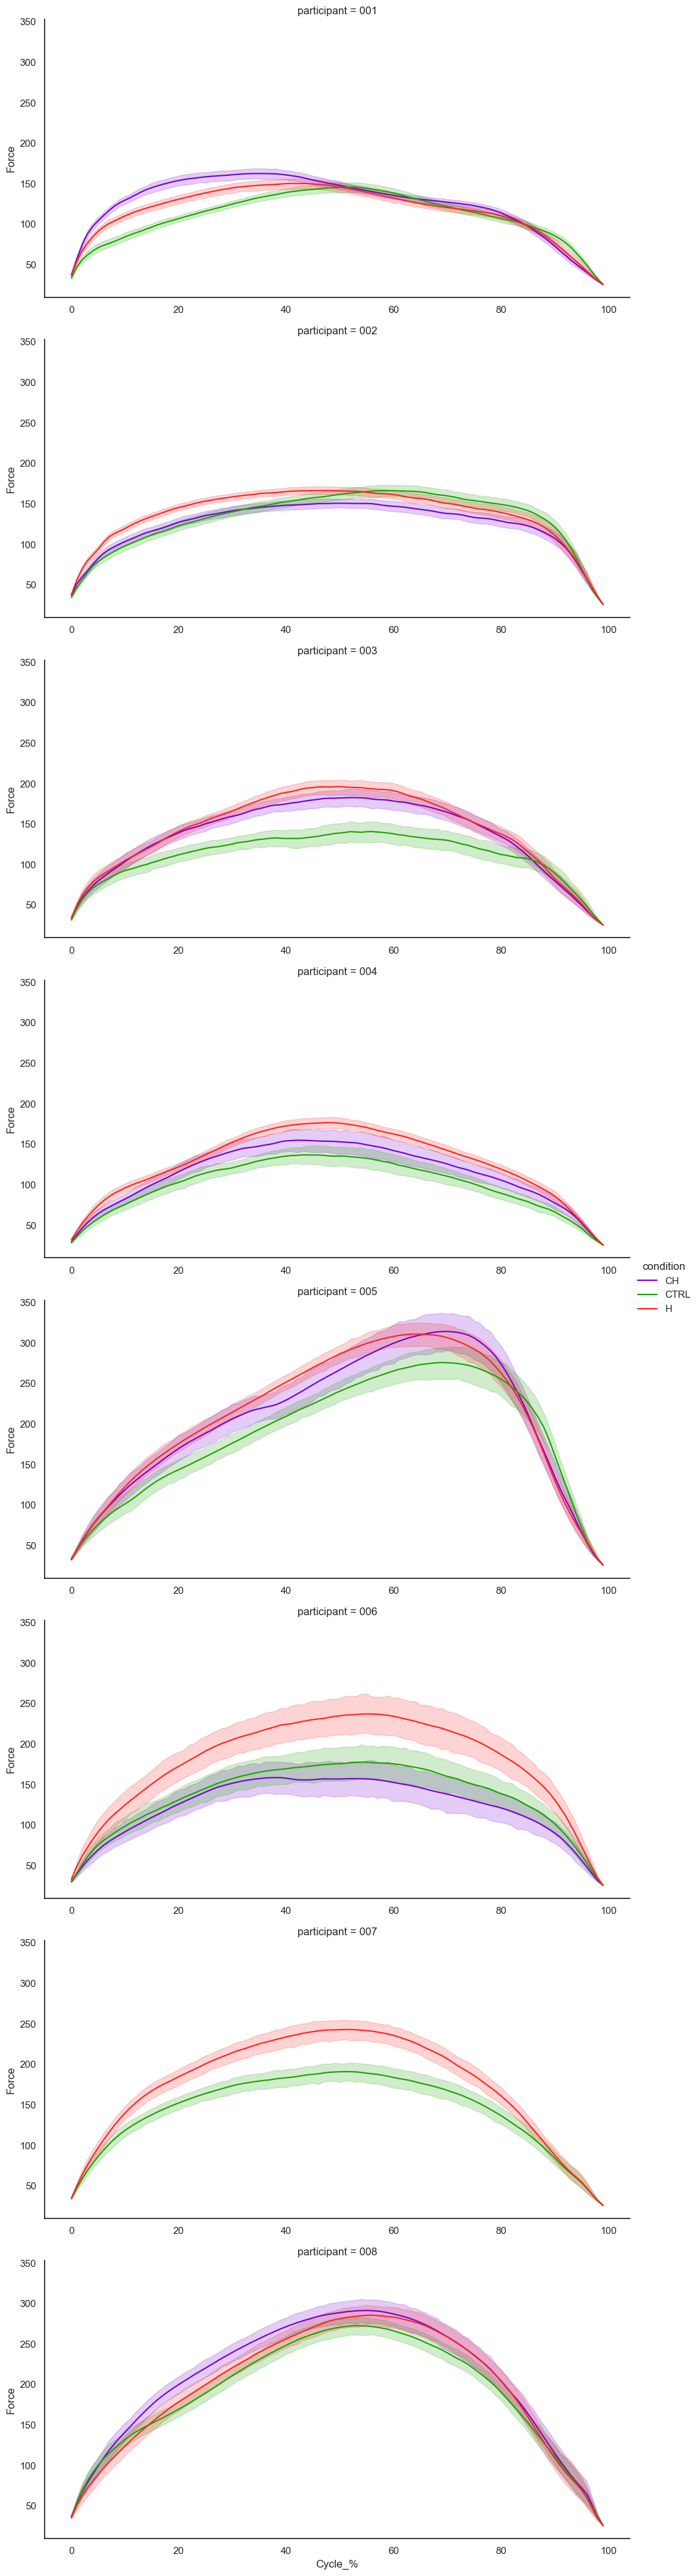

In [22]:
data_plot = df_flexion_interpol[
    # (df_flexion_interpol['participant'] == '001')
    (df_flexion_interpol['repetition'] != 0)
    # & (df_force_phase['condition'] == 'CTRL')
    # & (df_force_phase['contraction'] == 'CON60')
    # & (df_flexion_interpol['essai'] == '1')
    # & (df_flexion_interpol['mesure'] == '01')
    & (df_flexion_interpol['mouvement'] == 'Extension')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
            #  col = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )

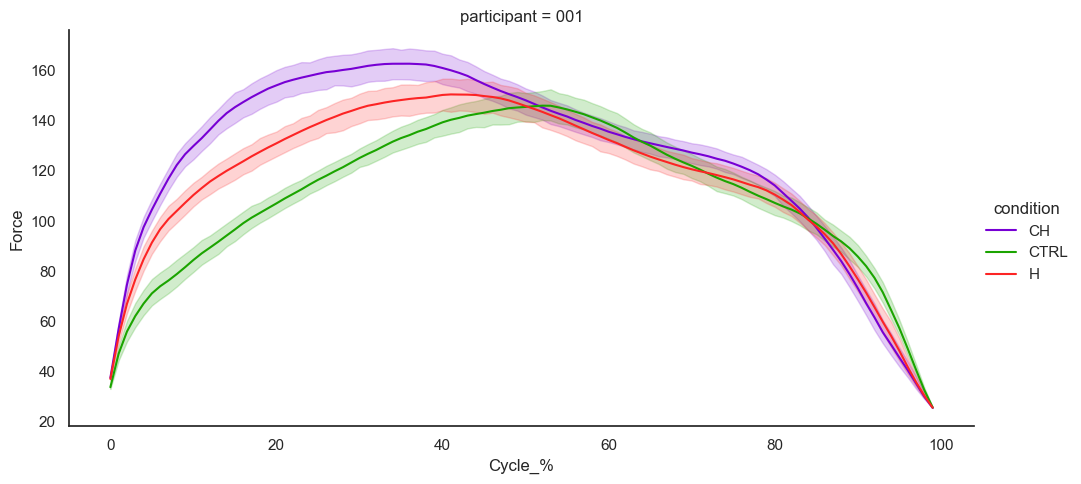

In [23]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['participant'] == '001')
    & (df_flexion_interpol['repetition'] != 0)
    # & (df_force_phase['condition'] == 'CTRL')
    # & (df_force_phase['contraction'] == 'CON60')
    # & (df_flexion_interpol['essai'] == '1')
    # & (df_flexion_interpol['mesure'] == '01')
    & (df_flexion_interpol['mouvement'] == 'Extension')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
            #  row = 'repetition',
             col = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )

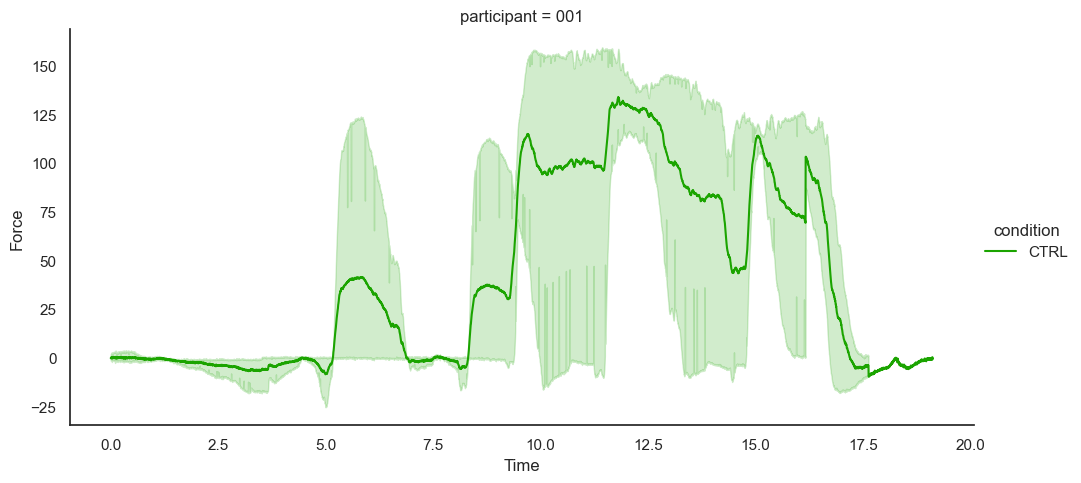

In [24]:
data_plot = df_column[
    (df_column['participant'] == '001')
    # & (df_column['repetition'] != 0)
    & (df_column['condition'] == 'CTRL')
    # & (df_force_phase['contraction'] == 'CON60')
    # & (df_column['essai'] == '2')
    & (df_column['mesure'] == '02')
    # & (df_column['mouvement'] == 'Extension')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Time',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
            #  row = 'mesure',
             col = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )